# Libor Market MonteCarlo Model (part 1)

## Pricing Zero Coupon Bond Option and Swaption Receiver

In this notebook, the first on the LMM topic, we set up a Libor Market Model where all forward rates are driven by the same Brownian motion. We then use the model to price two derivatives: an option on a Zero Coupon Bond and a Swaption Receiver. 

Both options have a 1 year maturity, with strikes at 0.90 and 3.5% respectively. 

The underlyings, the ZCB and the IRSwap, have both a maturity of 4 years, or 3 years from the time the options mature. 

The data for this exercise comes from Fixed Income Securities, Pietro Veronesi, pages 722 - 726. Pietro Veronesi also provided, in examples 21.5 and 21.6, respectively at pages 724 and 725, the two options prices: the ZCB option was priced at $0.5889$ and the swaption at $0.61074$ (per 100 principal). http://pietroveronesi.org/teaching/FIS/

When running our LMM algo we calculated the following values:

ZCB Option : 0.6001 vs. 0.5889 in the book

Swaption Receiver: 0.6081 vs 0.6107 in the book

We used 10,000 simulation and 256 daily steps

The original data, contains the Discount Factors and the Caplets' Forward Volatilities. Originally, the Caplets' Forward Volatilities were prepared in his book from the Black's formula.

We prepared the corresponding quarterly compounded forward rate outside this notebook.




The plan is as follows:

From the Caplets' forward Volatilities we extract the volatility of forward rates (with the formula at pages 721-722 in the book).

Once the volatilities are available, we set up the forward dynamics to price the two derivatives with maturity at $T = 1$ year.

The pricing is a Monte Carlo simulation where the forward rates are discretized at time steps, $dt$, of 1 day. 

The simulations start at year 1, when the options mature. We simulate $12$ forward rates, which are those necessary to value the simulated values of the $3$-$year$ ZCB and $3$-$year$ IR swap. 

The algo we use in the simulation is also provided in the book at page 723, and we report it below.

$$ f^{s}_n(t+dt,T_{i},T_{i+1}) = f^{s}_n(t,T_{i},T_{i+1}) e^{m^{s}_{i+1}(t)dt+S(T_{i+1}-t)\sqrt{dt}\epsilon^{s}_t}  $$

where:
$$ m^{s}_{i+1}(t) = \sum_{j=i^-}^{i} \frac{0.25f^{s}_n(t,T_{j},T_{j+1})S(T_{i+1}-t)S(T_{j+1}-t)}{f^{s}_n(t,T_{j},T_{j+1})} - \frac{1}{2}S(T_{i+1}-t)^{2}$$

- $\epsilon$ : is ~$N(0,1)$
- $s$ : is the simulation number
- $i^{-}$ : is the option maturity, which is year 1 in our case
- $i$ : are the times thereafter...

also note that all forward rates share the same $\epsilon$ ~$N(0,1)$

The options' values are calculated as follows:

$$ V^{ZCBOption} = Z(0,1)\frac{1}{10000}\sum_{i=1}^{10000}\left(Z^{s}(T_0,T_M)-0.9,0)\right) = 0.5889 $$

$$ V^{Swaption} = Z(0,1)\frac{1}{10000}\sum_{i=1}^{10000}\left(V^{swap,s}(T_0,T_M),0)\right) = 0.6107 $$


$$ V^{swap,s} = \sum_{i=1}^{3}\frac{0.035}{2}Z^{s}(T_0,T_i) + Z^{s}(T_0,T_M) - 1$$  
$$ i = .5, 1, 1.5, 2, 2.5, 3 $$

$$ Z^{s}(T_0,T_M) = \frac{1}{1+r_n(T_0,T_{0.25})} *\frac{1}{1+f_n(T_0,T_{0.25},T_{0.5})}*...*\frac{1}{1+f_n(T_0,T_{M-0.25},T_M)} $$

where:
- $T_M$ : is 4 years
- $T_0$ : is 1 year
- $Z^{s}(T_0,T_i)$ : is the future discount factor from the period $T_0$ and $T_i$
- $Z^{s}(T_0,T_M)$ : is the future discount factor from the period $T_0$ and $T_M$
- $Z(0,1)$ : is the current discount factor with maturity of $1$  $year$
- $r$ and $f$ : are the simulated rates from time $T_0$ when the options mature 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.interpolate import splrep, splev
import matplotlib.pyplot as plt
%matplotlib inline

Let's read our data set:

In [2]:
ForwardRates = pd.read_csv ('Exercise_21.csv', index_col=False)
print (ForwardRates.head(2))
print (ForwardRates.tail(2))
size = len(ForwardRates)

   Maturity        DF  FwdRate_qc  CapletsForwardVols
0      0.25  0.994580    0.021800             0.21156
1      0.50  0.988508    0.024568             0.22810
    Maturity        DF  FwdRate_qc  CapletsForwardVols
15      4.00  0.868212    0.045274              0.2682
16      4.25  0.858245    0.046454              0.2589


In [3]:
print (ForwardRates.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17 entries, 0 to 16
Data columns (total 4 columns):
Maturity              17 non-null float64
DF                    17 non-null float64
FwdRate_qc            17 non-null float64
CapletsForwardVols    17 non-null float64
dtypes: float64(4)
memory usage: 624.0 bytes
None


In [4]:
# We need functions to price 
# 1 . Swaption receiver
# 2 . ZCB and to calculate
# 3 . continously compounded forward and spot rates, from DFs
def ZCB(FwdRates):    
    # we assume rates are on a 3-month basis
    size = len(np.zeros(len(FwdRates)))

    # Prerare the forward discount factors    
    FDFs = 1/(1+FwdRates*0.25)
    
    # Prepare the spot discount factors
    DFs = np.cumprod(FDFs)
    
    # and return the Value of a ZCB
    return DFs[-1]

def CC_Spot_and_Forward(FwdRates):    

    size = len(np.zeros(len(FwdRates)))
    
    # Prerare the forward discount factors    
    FDFs  = 1/(1+FwdRates*0.25)
    ccfwd = -np.log(FDFs)/0.25
    
    # Prepare the spot discount factors
    DFs = np.cumprod(FDFs)
    j   = 0.25
    ccspot = np.zeros(size)
    for i, val in enumerate(DFs): 
        ccspot[i] = -np.log(val)/j
        j +=0.25
        
    return ccspot, ccfwd 

def SwapValue(FwdRates, rate):
    
    # The swap rates are calculated assuming semi-annual payments
    Swap_CFs = np.zeros(len(FwdRates))
    size     = len(Swap_CFs)

    # Prerare the forward discount factors    
    FDFs = 1/(1+FwdRates*0.25)
    
    # Prepare the spot discount factors
    DFs  = np.cumprod(FDFs)
    
    # Calculate the swap value
    for x in range(2, size + 1, 2):
        Swap_CFs[x-1] = rate*0.5*DFs[x-1]     
    
    Total_CFs_PV = np.sum(Swap_CFs) +  DFs[-1] 
    # and return the value
    return (Total_CFs_PV - 1)

We also need a function to interpolate between points on the volatility of the forward rates. 
The volatility vector $S$ above, where the simulation algo is provided, contains data $S(T_{j+1}-t)$ at points in time = {0.25, 0.50, ...}

In the algo above, as the simulations move ahead in time $t$, we need values between those points. For example after the first time step $dt$, $t$ has increased by $dt$, so we need volatility values at the points in time = {0.25 - dt, 0.50 - dt, ...} 

In [5]:
def f_cubic(x, x1, y1):
    ret = splrep(x1, y1)
    return splev(x, ret)

We prepare the volatility vectors of the forward rates: from the Caplets' vols we extract the volatility of forward rates. The formula is at pages 721-722 in the book.

In [6]:
CapletsForwardVols  =  np.asarray(ForwardRates.CapletsForwardVols)
size = len(CapletsForwardVols)

In [7]:
Vol_Fwd_Rate_S     = np.zeros(size)
Calc_S             = np.zeros(size)
Vol_Fwd_Rate_S[0]  = CapletsForwardVols[0]
Calc_S[0]          = CapletsForwardVols[0]**2*0.25
for i in range(1, size):
    x = CapletsForwardVols[i]**2 * ForwardRates.Maturity[i]
    y = np.sum(Calc_S)
    if(x>y):
        Vol_Fwd_Rate_S[i] = 2*np.sqrt(x-y)
    Calc_S[i] = Vol_Fwd_Rate_S[i]**2*0.25 

In [8]:
Vol_Fwd_Rate_S # are the S[] in the algo above

array([0.21156   , 0.24351917, 0.3027016 , 0.36136126, 0.40676204,
       0.42238968, 0.3754561 , 0.23526445, 0.10101094, 0.05529837,
       0.17359654, 0.27908415, 0.28428903, 0.24460043, 0.16843518,
       0.        , 0.        ])

and let's plot them against the orignal imputs

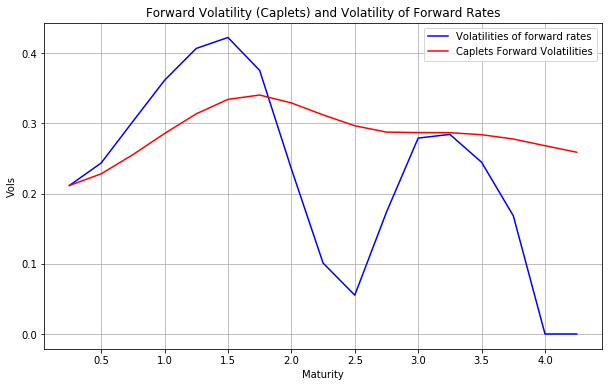

In [9]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:size], Vol_Fwd_Rate_S, lw=1.5, color='blue', label ='Volatilities of forward rates')
plt.plot(ForwardRates.Maturity[0:size], CapletsForwardVols, lw=1.5,   color='red', label ='Caplets Forward Volatilities')
plt.legend()
plt.xlabel('Maturity')  
plt.ylabel('Vols')
plt.grid(True)
plt.title("Forward Volatility (Caplets) and Volatility of Forward Rates");
plt.show()

We are ready now to write the simulations!

The rates are simulated daily, over a period of 256 trading days 

The model always assumes that the options mature in one year from now!

In [10]:
# ******************************************
# Do not change the following value 
# ******************************************
OptionMaturity  = 1   # The model can only deal with an option maturity at 1 year!  

In [11]:
'''Either 256 for daily simulations or 12 for monthy simulations''' 
SimulationPaths = 256

'''The maturity of the underlying fixed income security. So if today you want to price an option on a ZCB 
with a maturity of 3 years when the option matures, Maturity is 4 (one year after the option is exercised). 
'''
Maturity        = 4    

''' the number of forward rates that we are simulating.
 The model is set up to simulate quarterly compounded forward rates, with four forward rates per year. 
 So if the underlying matures at year 4, you need to simulate (4-1) * 4 = 12 forward rates! 
 These are the 12 forward rates, required to build the Discount Factor curve from when the option matures. '''
No_of_fwd_rates = (Maturity - OptionMaturity) * 4 

In [12]:
''' 
Do not increase the number of simulations. The model is slow. We have not optimized the runs. With 10,000 it takes 
around 5 minutes. 
'''
No_of_Simulations = 10000 # simulations

In [13]:
'''We will price two options: 
1. option on a ZCB and 
2. Swap Receiver
with the following strikes:
'''
ZCB_Strike      = 0.9
Swaption_Strike = 0.035

'''The following vectors will containg the Payoff of the two options'''
ZCB_Value         = np.zeros(No_of_Simulations)
Swap_Value        = np.zeros(No_of_Simulations)

In [14]:
'''Prepare a matrix of uncorrelated gaussian distributed numbers (with mean = 0 and sd = 1)  '''
npr.seed(1200)
StandardNormal = npr.standard_normal((SimulationPaths,No_of_Simulations))
StandardNormal.shape

(256, 10000)

In [15]:
# The current Forward rates
'''
Note that the first entry is the same as the current spot rate. 
The rates are compounded on a quarterly basis, all with tenors of 0.25 months.
We will ONLY need to simulate the forward rates starting from the period after the option matures. 
This is because to calcuate the option payoff, we need to calculate the Discounting Factors from after the option expires.
'''
FRqc    = np.asarray(ForwardRates.FwdRate_qc)

In [16]:
# Create a lower Diagonal Matrix
s           = (No_of_fwd_rates,No_of_fwd_rates)
DriftMatrix = np.ones(s) 
DriftMatrix = np.tril(DriftMatrix, k=0)

### Simulation
with 10,000 it take ~ 5 min's, or change to 1,000

In [17]:
# In case you do NOT need all simulated forward rates uncomment this
oldFRqcMatrix = np.zeros((No_of_fwd_rates,SimulationPaths +1 ,No_of_Simulations))

for j in range(0, No_of_Simulations):
    
    '''The option expires at the 4th quarter
    we simulate the forward rates starting from the period following the time the option expires'''
    oldFRqc              = FRqc[4:-1] 
    
    # In case you do NOT need all simulated forward rates uncomment this
    oldFRqcMatrix[:,0,j] = oldFRqc
    
    for i in range(0,int(SimulationPaths)):
        
        dt                   = i/float(SimulationPaths)
                
        DriftMatrix_FwdRates = DriftMatrix * 0.25*oldFRqc/(1+oldFRqc*0.25)
        VolFwdRate_toUpdate  = f_cubic(ForwardRates.Maturity - dt,ForwardRates.Maturity, Vol_Fwd_Rate_S)
        
        # outer product of the Fwd Rate volatilities         
        temp = np.multiply.outer(VolFwdRate_toUpdate[4:-1], VolFwdRate_toUpdate[4:-1])        
        
        DriftMatrix_FwdRates_Vol = DriftMatrix_FwdRates*temp
        mu      = (DriftMatrix_FwdRates_Vol.sum(axis=1)-0.5*VolFwdRate_toUpdate[4:-1]**2)*1/float(SimulationPaths)
        mu      = np.asarray(mu)
        
        vol     = VolFwdRate_toUpdate[4:-1]*StandardNormal[i,j]
        vol     = np.asarray(vol)
        
        muDrift = mu + vol*np.sqrt(1/float(SimulationPaths))
         
        NewFRqc = oldFRqc*np.exp(muDrift)
        oldFRqc = NewFRqc
        
        # In case you do NOT want to see all simulated forward rates uncomment this
        oldFRqcMatrix[:,i+1,j] = NewFRqc

            
    # Valuing the ZCB with the simulated forward rates
    ZCB_Value[j]  = ZCB(oldFRqc)
    
    # Valuing the Swaption with the simulated forward rates
    Swap_Value[j] = SwapValue(oldFRqc, Swaption_Strike)
    

In [18]:
# Prepare the forward and spot rates from the last simulation at the time when the options expire.
spot, forward = CC_Spot_and_Forward(oldFRqc)

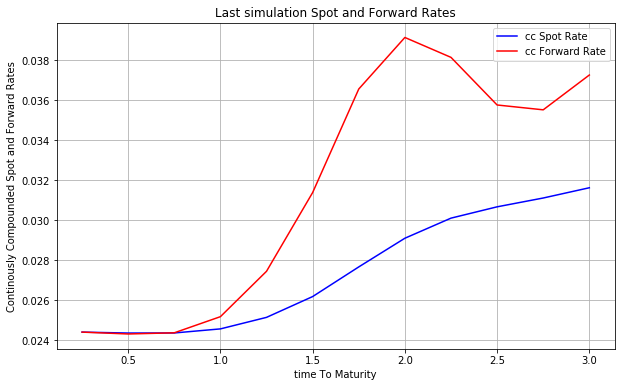

In [19]:
plt.figure(figsize=(10,6))
plt.plot(ForwardRates.Maturity[0:12], spot, lw=1.5, color='blue', label ='cc Spot Rate')
plt.plot(ForwardRates.Maturity[0:12], forward, lw=1.5,   color='red', label ='cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

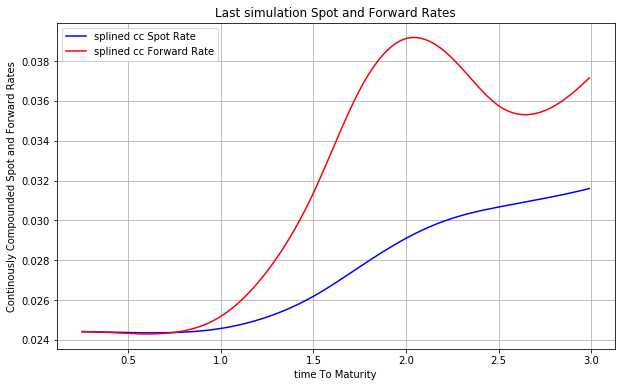

In [20]:
Maturities = np.arange (0.25, 3, 0.01)

plt.figure(figsize=(10,6))
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:12], spot), lw=1.5, color='blue', label ='splined cc Spot Rate')
plt.plot(Maturities, f_cubic(Maturities,ForwardRates.Maturity[0:12], forward), lw=1.5,   color='red', label ='splined cc Forward Rate')
plt.legend()
plt.xlabel('time To Maturity')  
plt.ylabel('Continously Compounded Spot and Forward Rates')
plt.grid(True)
plt.title("Last simulation Spot and Forward Rates");
plt.show()

In [21]:
print (np.round(np.mean(np.maximum(ZCB_Value   - ZCB_Strike,0)) * ForwardRates.DF[3]*100,5))
print (np.round(np.mean(np.maximum(Swap_Value,0))               * ForwardRates.DF[3]*100,5))

0.60007
0.6081


Our prices are only a bit off those reported by Pietro Veronesi. 

For the ZCB option, he reported 0.5889 vs ours of 0.6001.

For the Swaption Receiver, he reported 0.6107 vs ours of 0.6081.

Clearly, we might have made a mistake. However, we are not sure whether the rates were simulated with a daily frequency.
In addition, we do not know the interpolation routine that Pietro used for the Volatility of Forward Rates when the simulations are run. However, in the book it was mentioned the prices were calculated with 10,000 simulatons. 

In [22]:
''' 
Reassuringly, at time T= 1yr, the average value of the ZCB maturing at T = 4yr is super close to  the Forward Price 
which is implied in the current Discount Factor
'''

print (np.round(np.mean(ZCB_Value),4))
print (np.round(ForwardRates.DF[15] / ForwardRates.DF[3],4))

0.8911
0.8906


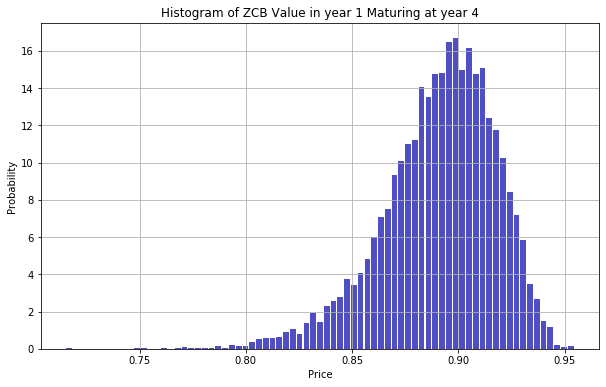

[0.0001 0.     0.     0.     0.     0.     0.     0.     0.     0.
 0.0002 0.0001 0.     0.     0.0002 0.     0.0002 0.0003 0.0001 0.0001
 0.0001 0.0002 0.0004 0.0001 0.0007 0.0004 0.0004 0.0012 0.0016 0.0018
 0.0019 0.002  0.0028 0.0034 0.0026 0.0044 0.0061 0.0046 0.0074 0.0082
 0.0088 0.012  0.011  0.013  0.0153 0.0191 0.0225 0.0239 0.0297 0.0321
 0.0351 0.0357 0.0449 0.0432 0.0471 0.0472 0.0526 0.0532 0.0477 0.0515
 0.047  0.0481 0.0396 0.0374 0.0327 0.0268 0.0229 0.0186 0.0111 0.0086
 0.0047 0.0038 0.0007 0.0003 0.0005]
1.0


In [23]:
''' 
Let's have a look at the distribution of the value of the ZCB at time T = 1, which matures at T = 4yr
'''
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=ZCB_Value, density = True, bins='auto', color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Price')
plt.ylabel('Probability')
plt.title('Histogram of ZCB Value in year 1 Maturing at year 4')
plt.show()

n /= np.sum(n)
print(np.round(n,5))
print(np.sum(n))

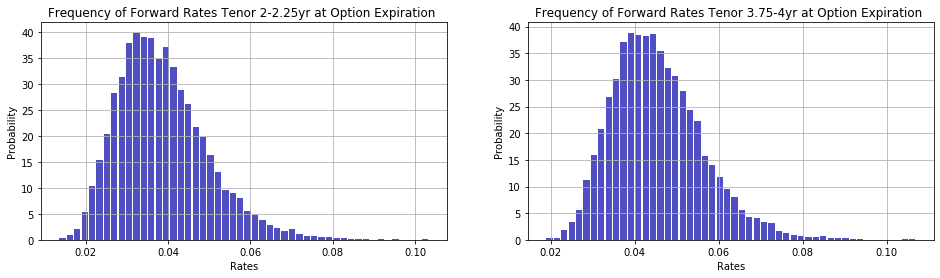

In [24]:
''' 
and before closing we report the distribution of two of the 12 forward rates at time T = 1. Both are very lognormal!
'''
plt.figure(figsize=(16,4))
plt.subplot(121)
n, bins, patches = plt.hist(x=oldFRqcMatrix[5,-1,:], density=True,bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Rates')
plt.ylabel('Probability')
plt.title("Frequency of Forward Rates Tenor 2-2.25yr at Option Expiration ")
plt.subplot(122)
n, bins, patches = plt.hist(x=oldFRqcMatrix[11,-1,:], density = True, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
plt.grid(True)
plt.xlabel('Rates')
plt.ylabel('Probability')
plt.title("Frequency of Forward Rates Tenor 3.75-4yr at Option Expiration ")
plt.show()